To get started with demand forecasting, click [here](https://colab.research.google.com/github/saschaschworm/big-data-and-data-science/blob/master/labs/demand-forecasting.ipynb) to open the Jupyter Notebook in your Google Colab account. This notebook contains the exercises and code you can work through directly in Colab. If you’d like to check your work or explore the completed solution, click [here](https://colab.research.google.com/github/saschaschworm/big-data-and-data-science/blob/master/labs/demand-forecasting-solution.ipynb) to import the solution notebook into Google Colab. Both resources are designed to help you deepen your understanding of demand forecasting and apply data science techniques hands-on.

## Business Understanding

FreshMart, a local supermarket, struggles with managing the inventory of freshly prepared salads, which must be sold the same day they are delivered due to a one-day shelf life. The current ordering method, based on demand from exactly seven days ago plus a 10 % buffer, often results in either overstocking, leading to waste, or understocking, causing missed sales. To address these issues, FreshMart has initiated a data-driven project to improve inventory management.

### Business Objectives

The project's main objective is to **reduce salad waste while ensuring sufficient stock to meet demand**, balancing waste reduction with product availability to improve inventory efficiency, profitability, and customer satisfaction.

### Situtation Assessment

Currently, FreshMart uses a simple but flawed method to order salads, which doesn't account for daily demand fluctuations. The market has valuable resources like historical sales data but faces challenges such as the **salads' short shelf life**, **seasonal demand variations**, and **limited storage**. The risks include financial loss from **waste due to overestimation** and missed sales from **stockouts due to underestimation**.

### Data Mining Goals

The goal of the data mining process is to **develop a predictive model to accurately forecast daily salad demand**, enabling more informed ordering decisions. This model aims to create a dynamic system that provides **real-time order recommendations**, **reducing waste** and **improving stock availability**.

### Project Plan

The project is divided into five phases: data collection and preparation, exploratory data analysis and feature engineering, model development and testing, implementation and integration, and monitoring and optimization. These phases will ensure the chosen model is integrated into the inventory management system, with a focus on continuous performance tracking and adjustment.

### Initial Assessment of Tools and Techniques

Linear regression will be the primary modeling technique, with Python used for data analysis, modeling, visualization, and reporting. The data is available in CSV or Feather formats, eliminating the need for SQL databases. The model's performance will be evaluated using Root Mean Square Error (RMSE) and business metrics like waste reduction and stock turn rate improvement.

### Success Criteria Determination

Success will be measured by both business and technical criteria. Business success involves **reducing salad waste by at least 70 %**, **increasing profitability 80 %**, and **maintaining at least 50 %** in-stock rate. On the technical side, success will be determined by achieving at least **20** RMSE, and providing real-time order recommendations.

## Setup, Configuration, and Utilities

### Package Installation

In [1]:
# This installs the necessary libraries. If you're not working in Google Colab, alternatives like Poetry may also work 
# for managing dependencies. You can refer to the pyproject.toml in the GitHub repository for more information.
#
# !pip install -q feature_engine pyampute

### Package Import

In [2]:
# Third-Party Packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn

from feature_engine.pipeline import make_pipeline
from feature_engine.wrappers import SklearnTransformerWrapper

from holidays import country_holidays

from matplotlib.dates import DateFormatter
from matplotlib.ticker import FixedFormatter, FixedLocator, MultipleLocator, PercentFormatter

from pandas import DataFrame

from scipy import stats
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import KFold, RandomizedSearchCV, TimeSeriesSplit, cross_validate, train_test_split
from sklearn.preprocessing import FunctionTransformer, PolynomialFeatures, StandardScaler

In [3]:
try:
    from google.colab import data_table
    data_table.enable_dataframe_formatter()
except ModuleNotFoundError:
    pass

### Package Configuration

In [4]:
# Configuration for Matplotlib and Seaborn
sns.set_theme(style="darkgrid")

# Configuration for Pandas
pd.set_option("display.max_rows", 11)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.float_format", lambda x: f"{x:,.4f}")

# Configuration for Scikit-Learn
sklearn.set_config(transform_output="pandas")

### Custom Helper Methods

In [5]:
def get_business_metrics(transactions: DataFrame):
    """Calculate key business metrics from transaction data.

    This function computes various key performance indicators (KPIs) related to inventory and sales based on the 
    provided transaction data.

    Args:
        transactions (DataFrame): A data frame with the following required columns: actual demand for the product 
            (`DEMAND`), purchased quantity of the product (`PQTY`), cost of excess inventory (`CEI`), cost of lost 
            sales (`CLS`), sales revenue (`SR`), purchase cost (`PC`), gross profit (`GP`), net profit (`NP`), and 
            inventory levels (`INVENTORY`).
    
    Returns:
        DataFrame: A data frame containing the calculated KPIs with the following columns: the name of the key 
            performance indicator (`KPI`), a brief description of the KPI (`DESCRIPTION`), and the calculated value of 
            the KPI, formatted as a string (`VALUE`).

    Raises:
        KeyError: If required columns are missing in the input data frame.
    """

    metrics = DataFrame(columns=["KPI", "DESCRIPTION", "VALUE"])
    metrics.loc[len(metrics), :] = ["Root Mean Squared Error", "Measures the average difference between actual demand and purchased quantity.", f"{root_mean_squared_error(transactions['DEMAND'], transactions['PQTY']):,.2f} UNITS"]
    metrics.loc[len(metrics), :] = ["Total Cost of Inefficiency", "The combined cost of excess inventory and lost sales.", f"{(transactions['CEI'] + transactions['CLS']).sum():,.2f} EUR"]
    metrics.loc[len(metrics), :] = ["Total Sales Revenue", "Total revenue generated from sales.", f"{transactions['SR'].sum():,.2f} EUR"]
    metrics.loc[len(metrics), :] = ["Total Purchase Cost", "Total cost incurred from purchasing goods.", f"{transactions['PC'].sum():,.2f} EUR"]
    metrics.loc[len(metrics), :] = ["Total Gross Profit", "Total profit before accounting for overhead costs.", f"{transactions['GP'].sum():,.2f} EUR"]
    metrics.loc[len(metrics), :] = ["Total Net Profit", "Total profit after all expenses have been deducted.", f"{transactions['NP'].sum():,.2f} EUR"]
    metrics.loc[len(metrics), :] = ["Total Waste Rate", "Percentage of inventory left over (waste) compared to total purchased quantity.", f"{np.abs(transactions[transactions['INVENTORY'] > 0]['INVENTORY'].sum()) / sum(transactions['PQTY']) * 100:,.2f} %"]
    metrics.loc[len(metrics), :] = ["Total Waste Quantity", "Total number of units left as waste.", f"{np.abs(transactions[transactions['INVENTORY'] > 0]['INVENTORY'].sum())} UNITS"]
    metrics.loc[len(metrics), :] = ["Overstock Rate", "Percentage of records where there is excess inventory.", f"{len(transactions[transactions['INVENTORY'] > 0]) / len(transactions) * 100:,.2f} %"]
    metrics.loc[len(metrics), :] = ["Understock Rate", "Percentage of records where there is a shortage of inventory.", f"{len(transactions[transactions['INVENTORY'] < 0]) / len(transactions) * 100:,.2f} %"]
    metrics.loc[len(metrics), :] = ["Perfect Order Rate", "Percentage of records where the inventory matched demand perfectly.", f"{len(transactions[transactions['INVENTORY'] == 0]) / len(transactions) * 100:,.2f} %"]
    return metrics

In [6]:
def get_inventory_metrics(transactions: DataFrame, target = "DEMAND"):
    """Calculate detailed inventory and financial metrics from transaction data.

    This function computes key financial metrics related to inventory, such as purchase cost, gross profit, inventory 
    levels, cost of excess inventory, cost of lost sales, and net profit, based on the provided transaction data.

    Args:
        transactions (DataFrame): A data frame containing the following required columns: purchase price per unit of 
            the product (`PPRC`), purchased quantity of the product (`PQTY`), actual demand for the product (`DEMAND`), 
            unit gross profit (profit per unsatisfied demand) (`UGP`).

    Returns:
        DataFrame: A data frame containing the calculated metrics with the following columns: total purchase cost 
            (`PC`), gross profit (`GP`), inventory levels (`INVENTORY`), cost of excess inventory (`CEI`), cost of lost 
            sales (`CLS`), net profit (`NP`), sales revenue for the product (`SR`), sales quantity (`SQTY`).

    Raises:
        KeyError: If required columns are missing in the input data frame.
    """

    metrics = DataFrame(columns=["PC", "GP", "INVENTORY", "CEI", "CLS", "NP", "SQTY", "SR"], index=transactions.index)
    metrics["PC"] = (transactions["PPRC"] * transactions["PQTY"]).round(2)
    metrics["SQTY"] = transactions[target].case_when([(lambda demand: demand >= transactions["PQTY"], transactions["PQTY"]), (lambda demand: demand < transactions["PQTY"], transactions["DEMAND"])])
    metrics["SR"] = (transactions["RPRC"] * metrics["SQTY"]).round(2)
    metrics["GP"] = (metrics["SR"] - metrics["PC"]).round(2)
    metrics["INVENTORY"] = transactions["PQTY"] - transactions["DEMAND"]
    metrics["CEI"] = metrics["INVENTORY"].case_when([(lambda x: x > 0, metrics["INVENTORY"] * transactions["PPRC"]), (lambda x: x <= 0, 0)]).round(2)
    metrics["CLS"] = metrics["INVENTORY"].case_when([(lambda x: x < 0,  -1 * metrics["INVENTORY"] * transactions["UGP"]), (lambda x: x >= 0, 0)]).round(2)
    metrics["NP"] = (metrics["GP"] - metrics["CLS"]).round(2)
    return metrics

### Custom Data Transformers

In [7]:
ForwardFillTransformer = FunctionTransformer(lambda x: x.copy().ffill())

## Data Understanding

This phase involves getting acquainted with the data, identifying quality issues, and uncovering insights to guide the project's next steps. This phase typically starts with collecting relevant data from databases, files, or external sources. The data is then summarized to understand its structure, including variable types (categorical or numerical), record counts, and basic statistics like mean, median, standard deviation, and distributions. Exploratory Data Analysis (EDA) follows, using visualizations like histograms, scatter plots, and box plots to reveal patterns, trends, and relationships. Finally, data quality is assessed by identifying issues such as missing values, outliers, and inconsistencies, which are crucial to address in the Data Preparation phase.

### Historic Retail Transactions Dataset

In [8]:
transactions = pd.read_feather("https://github.com/saschaschworm/big-data-and-data-science/raw/refs/heads/master/datasets/demand-forecasting.feather")

#### Data Dictionary

| **Field Name**  | **Data Type** | **Description**                                                                                                     |
|-----------------|---------------|---------------------------------------------------------------------------------------------------------------------|
| `ODATE`         | `str`         | The order date when all relevant information becomes available to predict the demand on the target date (`TDATE`). |
| `TDATE`         | `str`         | The target date for which the demand and other metrics are being predicted. This is the actual date for which the forecast is applicable. |
| `SEASON`        | `str`         | The season (e.g., Winter, Spring, Summer, Fall) at the target date (`TDATE`). |
| `DEMAND`        | `int`         | The actual number of units demanded or sold on the target date (`TDATE`). This is the realized demand and serves as the ground truth for evaluating the accuracy of the forecast. |
| `DEMAND7CD`     | `int`         | The actual number of units demanded or sold 7 calendar days before the target date (`TDATE`). This metric reflects the realized demand on week prior to the target date. |
| `MARKETING`     | `str`         | The level of marketing effort deployed on the target date (`TDATE`). This is typically categorized as `LOW`, `MEDIUM`, or `HIGH`, and represents the intensity of marketing campaigns, advertisements, or promotions aimed at driving sales. |
| `PROMOTION`     | `str`         | The type of promotion applied on the target date (`TDATE`), such as `NONE`, `DISCOUNT`, or `BOGO`. Promotions can have a significant impact on demand by incentivizing purchases. |
| `CAF`           | `str`         | An indicator of whether a competitor is currently running an active marketing campaign on the target date (`TDATE`). This is a binary field with values `YES` or `NO`, where `YES` indicates that a competitor has an active campaign, which could potentially impact demand. |
| `TEMPERATURE`   | `float`       | The forecasted temperature (in degrees Celsius) expected on the target date (`TDATE`), as predicted on the prediction date (`ODATE`). Weather conditions can influence consumer behavior, especially for certain seasonal products. |
| `PRECIPITATION` | `float`       | The forecasted probability of precipitation expected on the target date (`TDATE`), as predicted on the prediction date (`ODATE`). This metric represents the likelihood of rain or other forms of precipitation, which can affect foot traffic and overall demand. |
| `PPRC`          | `float`       | The purchase price per unit on the target date (`TDATE`). This is the cost at which the supermarket acquires each unit of the product from suppliers, and it directly influences the cost of goods sold (COGS). |
| `RPRC`          | `float`       | The sale price per unit on the target date (`TDATE`). This is the price at which the supermarket sells each unit to customers. It is a crucial factor in determining revenue and profitability. |
| `PQTY`          | `int`         | The quantity of units purchased on the target date (`TDATE`). This reflects the inventory replenishment made by the supermarket to meet anticipated demand. |
| `SQTY`          | `int`         | The quantity of units sold on the target date (`TDATE`). This is the actual sales volume achieved on the target date and is used to calculate revenue and inventory levels. |
| `INVENTORY`     | `int`         | The stock level on the target date (`TDATE`) after accounting for sales and purchases. A positive value indicates surplus inventory (overstocking), while a negative value indicates a shortage (understocking). Inventory management is critical for minimizing holding costs and avoiding lost sales. |
| `UGP`           | `float`       | The unit gross profit on the target date (`TDATE`), calculated as the difference between the sale price (`RPRC`) and the purchase price (`PPRC`). This metric indicates the profit margin per unit sold. |
| `SR`            | `float`       | The total sales revenue on the target date (`TDATE`), calculated as the product of the quantity sold (`SQTY`) and the sale price (`RPRC`). Sales revenue is a key indicator of the supermarkets's top-line performance. |
| `PC`            | `float`       | The total purchase cost on the target date (`TDATE`), calculated as the product of the quantity purchased (`PQTY`) and the purchase price (`PPRC`). This represents the total expenditure on acquiring inventory. |
| `GP`            | `float`       | The gross profit on the target date (`TDATE`), calculated as the difference between total sales revenue (`SR`) and total purchase cost (`PC`). Gross profit indicates the profitability before accounting for operating expenses. |
| `CEI`           | `float`       | The cost of excessive inventory on the target date (`TDATE`). This represents the holding costs incurred due to overstocking. Holding costs can include storage, insurance, spoilage, and depreciation of unsold goods. It is calculated based on the excess units in inventory that exceed expected demand. High CEI indicates inefficient inventory management and can negatively impact profitability. |
| `CLS`           | `float`       | The cost of lost sales due to understocking on the target date (`TDATE`). This cost represents the opportunity loss when demand exceeds available inventory, leading to missed sales opportunities. Understocking can result in dissatisfied customers and potential loss of market share. The cost is typically estimated based on the profit that could have been earned if sufficient inventory had been available. |
| `NP`            | `float`       | The net profit on the target date (`TDATE`), calculated as the difference between gross profit (`GP`) and the cost of lost sales (`CLS`). Net profit is a key measure of overall profitability after accounting for all relevant costs, including inefficiencies in inventory management. |

#### Preliminary Data Analysis

In [9]:
transactions

,ODATE,TDATE,SEASON,DEMAND,DEMAND7CD,MARKETING,PROMOTION,CAF,TEMPERATURE,PRECIPITATION,PPRC,RPRC,PQTY,SQTY,INVENTORY,UGP,SR,PC,GP,CEI,CLS,NP
0,2023-08-31,2023-09-01,FALL,218,276,MEDIUM,NONE,NO,28.1000,0.0759,3.1800,3.9900,304,218,86,0.8100,869.8200,966.7200,-96.9000,273.4800,0.0000,-96.9000
1,2023-09-01,2023-09-02,FALL,240,261,MEDIUM,NONE,NO,28.0000,0.0790,3.1200,3.9900,287,240,47,0.8700,957.6000,895.4400,62.1600,146.6400,0.0000,62.1600
2,2023-09-02,2023-09-04,FALL,177,284,LOW,DISCOUNT,YES,26.7000,0.0854,3.1800,3.8900,312,177,135,0.7100,688.5300,992.1600,-303.6300,429.3000,0.0000,-303.6300
3,2023-09-04,2023-09-05,FALL,199,236,LOW,DISCOUNT,YES,<NA>,0.0887,2.8000,3.3900,260,199,61,0.5900,674.6100,728.0000,-53.3900,170.8000,0.0000,-53.3900
4,2023-09-05,2023-09-06,FALL,154,264,LOW,NONE,YES,25.8000,0.0920,3.1800,3.9900,290,154,136,0.8100,614.4600,922.2000,-307.7400,432.4800,0.0000,-307.7400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,2024-08-26,2024-08-27,SUMMER,314,318,MEDIUM,NONE,YES,27.7000,0.0640,2.0000,2.5900,350,314,36,0.5900,813.2600,700.0000,113.2600,72.0000,0.0000,113.2600
299,2024-08-27,2024-08-28,SUMMER,278,270,LOW,NONE,YES,29.5000,0.0669,2.0800,2.6900,297,278,19,0.6100,747.8200,617.7600,130.0600,39.5200,0.0000,130.0600
300,2024-08-28,2024-08-29,SUMMER,337,279,HIGH,NONE,YES,28.3000,0.0698,1.9700,2.4900,307,307,-30,0.5200,764.4300,604.7900,159.6400,0.0000,15.6000,144.0400
301,2024-08-29,2024-08-30,SUMMER,330,344,MEDIUM,NONE,YES,28.4000,0.0728,1.9100,2.3900,378,330,48,0.4800,788.7000,721.9800,66.7200,91.6800,0.0000,66.7200


In [10]:
transactions.dtypes.to_frame().transpose()

,ODATE,TDATE,SEASON,DEMAND,DEMAND7CD,MARKETING,PROMOTION,CAF,TEMPERATURE,PRECIPITATION,PPRC,RPRC,PQTY,SQTY,INVENTORY,UGP,SR,PC,GP,CEI,CLS,NP
0,datetime64[ns],datetime64[ns],category,Int64,Int64,category,category,category,Float64,Float64,Float64,Float64,Int64,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64


In [11]:
transactions.describe(include="all")

,ODATE,TDATE,SEASON,DEMAND,DEMAND7CD,MARKETING,PROMOTION,CAF,TEMPERATURE,PRECIPITATION,PPRC,RPRC,PQTY,SQTY,INVENTORY,UGP,SR,PC,GP,CEI,CLS,NP
count,303,303,303,303.0000,303.0000,303,296,303,295.0000,303.0000,303.0000,303.0000,303.0000,303.0000,303.0000,303.0000,303.0000,303.0000,303.0000,303.0000,303.0000,303.0000
unique,NaN,NaN,4,<NA>,<NA>,3,3,2,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
top,NaN,NaN,SUMMER,<NA>,<NA>,LOW,NONE,NO,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
freq,NaN,NaN,79,<NA>,<NA>,205,216,279,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
mean,2024-03-01 00:00:00,2024-03-02 04:59:24.356435712,NaN,223.3630,224.9274,NaN,NaN,NaN,10.3403,0.2481,3.0868,3.8867,247.4554,216.7855,24.0924,0.7999,796.2031,728.6579,67.5452,96.3253,5.0613,62.4839
min,2023-08-31 00:00:00,2023-09-01 00:00:00,NaN,69.0000,69.0000,NaN,NaN,NaN,-17.8000,0.0000,1.7400,2.1900,76.0000,69.0000,-83.0000,0.3800,385.7100,318.8600,-480.1000,0.0000,0.0000,-480.1000
25%,2023-11-29 12:00:00,2023-11-30 12:00:00,NaN,179.0000,181.0000,NaN,NaN,NaN,-7.5000,0.0698,2.2300,2.7900,199.0000,175.0000,3.5000,0.6050,667.0650,594.7500,31.7850,9.4500,0.0000,31.7850
50%,2024-02-29 00:00:00,2024-03-01 00:00:00,NaN,216.0000,218.0000,NaN,NaN,NaN,10.6000,0.2468,2.9700,3.7900,240.0000,208.0000,26.0000,0.7800,759.9900,684.7800,86.6700,71.7600,0.0000,83.5400
75%,2024-06-03 12:00:00,2024-06-04 12:00:00,NaN,268.0000,269.5000,NaN,NaN,NaN,28.0500,0.4256,3.2350,4.0900,296.5000,256.0000,45.5000,0.8700,880.2600,829.3550,135.0300,129.0150,0.0000,124.2150
max,2024-08-30 00:00:00,2024-08-31 00:00:00,NaN,378.0000,377.0000,NaN,NaN,NaN,36.6000,0.5000,4.7400,5.9900,415.0000,378.0000,160.0000,1.2600,"1,684.8900","1,590.3000",252.7200,670.5000,69.6000,247.8600


In [12]:
get_business_metrics(transactions)

,KPI,DESCRIPTION,VALUE
0,Root Mean Squared Error,Measures the average difference between actual demand and purchased quantity.,46.61 UNITS
1,Total Cost of Inefficiency,The combined cost of excess inventory and lost sales.,"30,720.14 EUR"
2,Total Sales Revenue,Total revenue generated from sales.,"241,249.54 EUR"
3,Total Purchase Cost,Total cost incurred from purchasing goods.,"220,783.34 EUR"
4,Total Gross Profit,Total profit before accounting for overhead costs.,"20,466.20 EUR"
5,Total Net Profit,Total profit after all expenses have been deducted.,"18,932.63 EUR"
6,Total Waste Rate,Percentage of inventory left over (waste) compared to total purchased quantity.,12.39 %
7,Total Waste Quantity,Total number of units left as waste.,9293 UNITS
8,Overstock Rate,Percentage of records where there is excess inventory.,76.57 %
9,Understock Rate,Percentage of records where there is a shortage of inventory.,23.10 %


#### Exploratory Data Analysis

##### Line Plot: Transaction Date and Demand

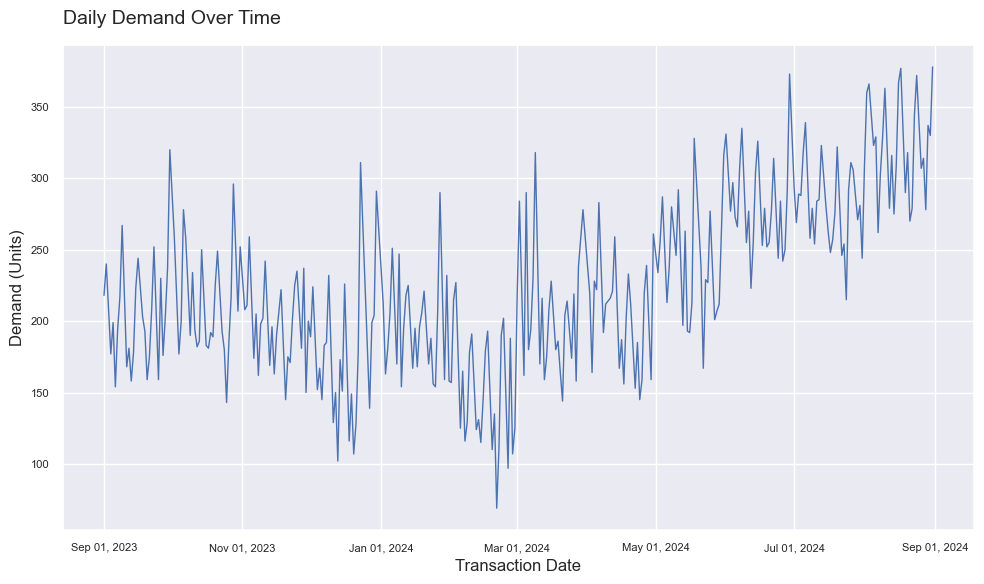

In [13]:
fig = plt.figure(figsize=(10, 6))
ax = sns.lineplot(x="TDATE", y="DEMAND", data=transactions, linewidth=1, alpha=1.0)

ax.set_title("Daily Demand Over Time", loc="left", fontsize=14, pad=15)
ax.set_xlabel("Transaction Date", fontsize=12)
ax.set_ylabel("Demand (Units)", fontsize=12)

ax.tick_params(axis="x", labelsize=8)
ax.tick_params(axis="y", labelsize=8)

ax.xaxis.set_major_formatter(DateFormatter("%b %d, %Y"))

fig.tight_layout()

##### Scatter Plot: Retail Price and Demand

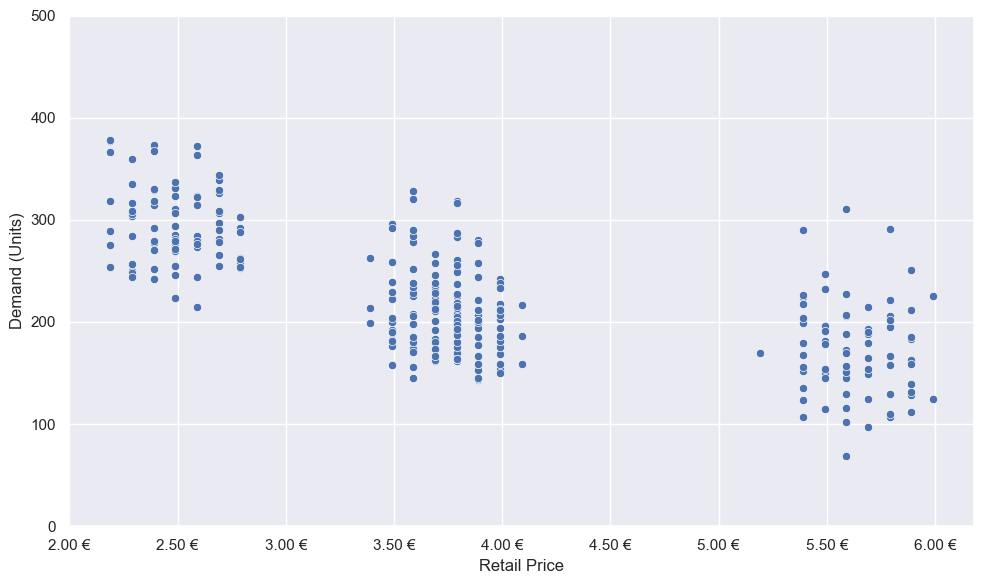

In [14]:
fig = plt.figure(figsize=(10, 6))
ax = sns.scatterplot(x="RPRC", y="DEMAND", data=transactions)

ax.set_xlabel("Retail Price")
ax.set_ylabel("Demand (Units)")
ax.set_ylim(0, 500)

ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.xaxis.set_major_formatter("{x:.2f} €")

fig.tight_layout()

##### Scatter Plot: Precipitation, Competitor Activity, and Demand

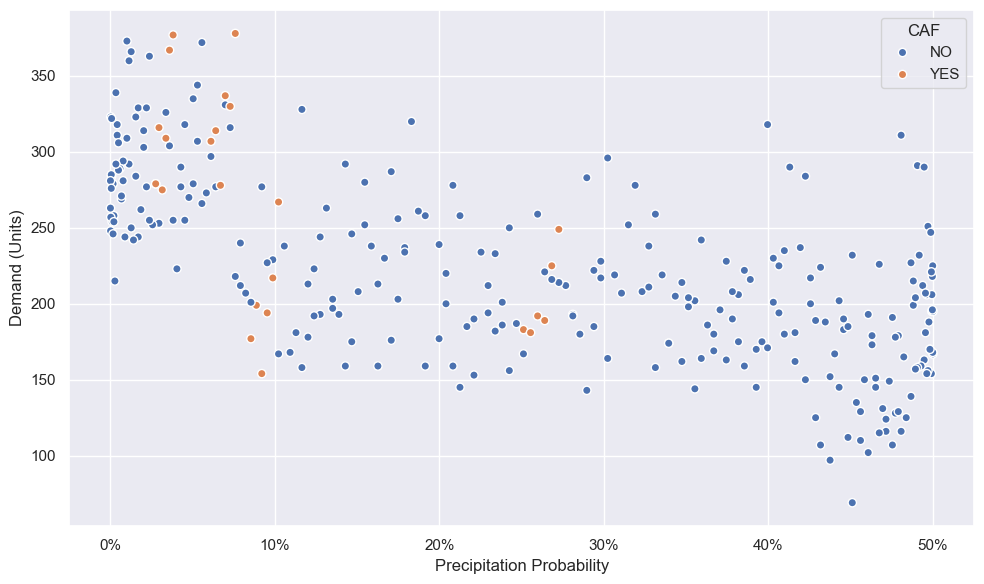

In [15]:
fig = plt.figure(figsize=(10, 6))
ax = sns.scatterplot(x="PRECIPITATION", y="DEMAND", hue="CAF", data=transactions, linewidth=1, alpha=1.0)

ax.set_xlabel("Precipitation Probability")
ax.set_ylabel("Demand (Units)")

ax.xaxis.set_major_formatter(PercentFormatter(xmax=1))

fig.tight_layout()

##### Box and Whisker Plot: Season and Demand

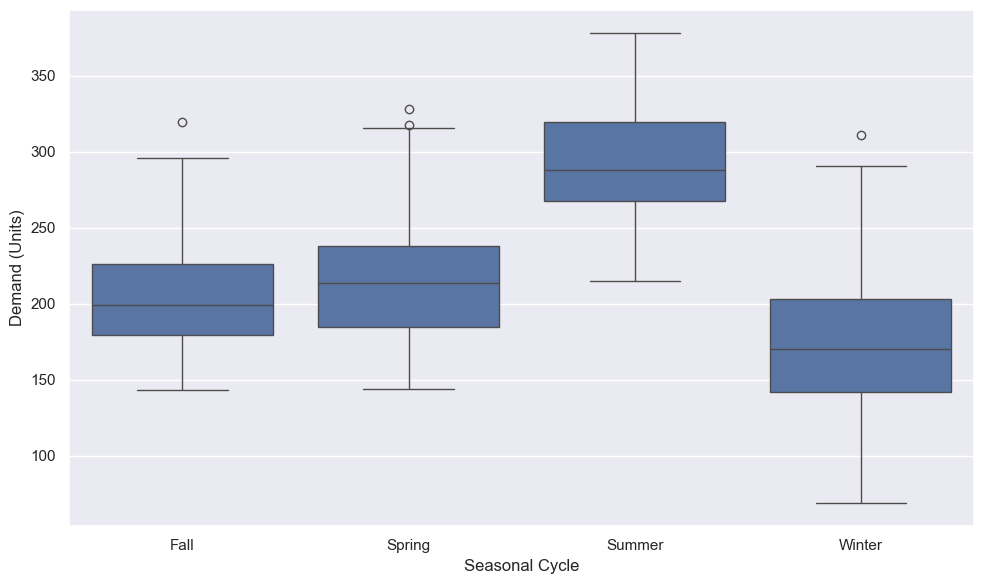

In [16]:
fig = plt.figure(figsize=(10, 6))
ax = sns.boxplot(x="SEASON", y="DEMAND", data=transactions)

ax.set_xlabel("Seasonal Cycle")
ax.set_ylabel("Demand (Units)")

ax.xaxis.set_major_locator(FixedLocator([0, 1, 2, 3]))
ax.xaxis.set_major_formatter(FixedFormatter(["Fall", "Spring", "Summer", "Winter"]))

fig.tight_layout()

##### Scatter Plot: Forecasted Temperature and Demand

**Exercise:** Create a scatter plot to analyze the relationship between temperature and demand. What trends can you identify in how temperature affects demand?

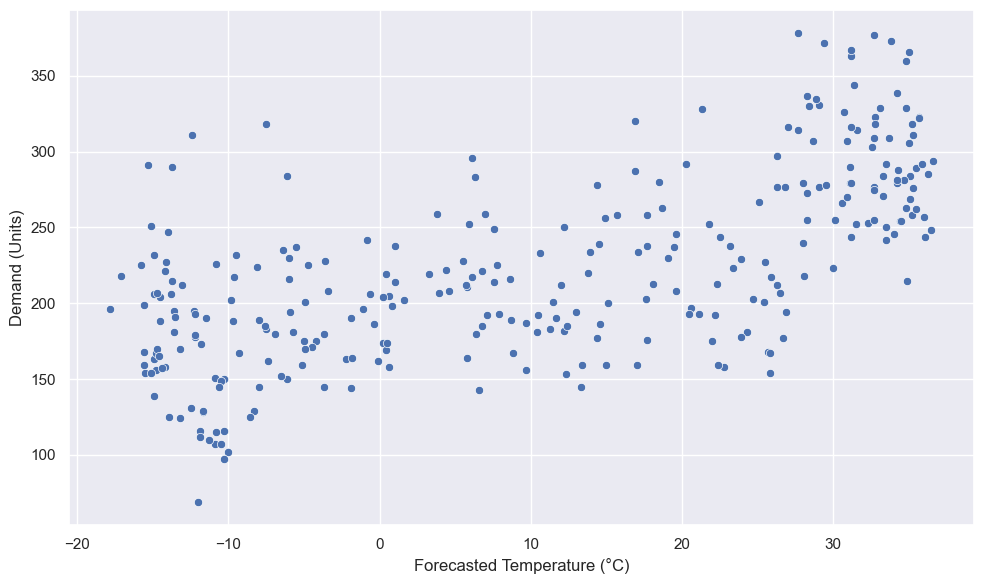

In [17]:
fig = plt.figure(figsize=(10, 6))
ax = sns.scatterplot(x="TEMPERATURE", y="DEMAND", data=transactions)

ax.set_xlabel("Forecasted Temperature (°C)")
ax.set_ylabel("Demand (Units)")

fig.tight_layout()

##### Box and Whisker Plot: Promotion and Demand

**Exercise:** Create a box plot to compare the effectiveness of different promotion types on demand, and identify which promotion type leads to the highest demand.

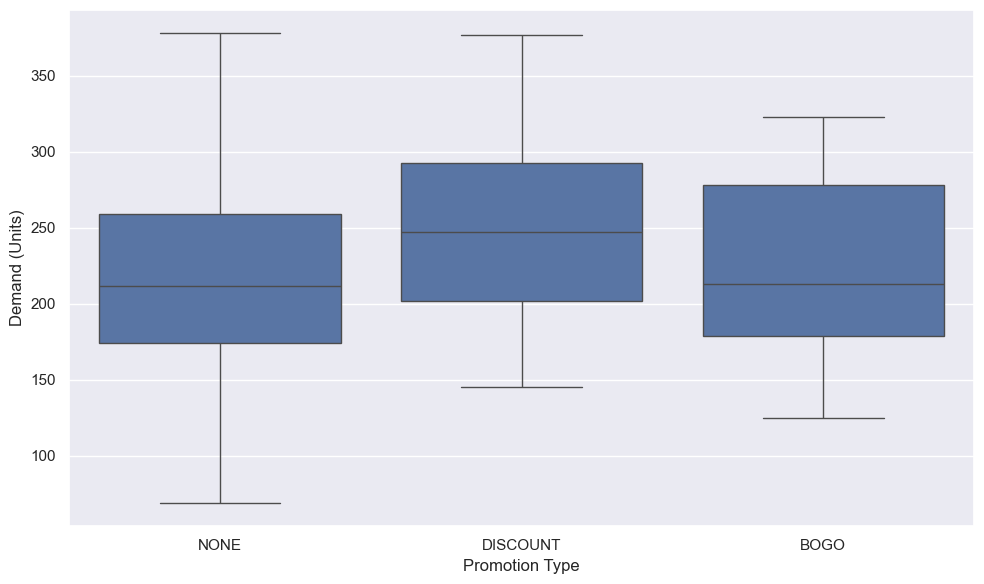

In [18]:
fig = plt.figure(figsize=(10, 6))
ax = sns.boxplot(x="PROMOTION", y="DEMAND", data=transactions)

ax.set_xlabel("Promotion Type")
ax.set_ylabel("Demand (Units)")

fig.tight_layout()

##### Box and Whisker Plot: Competitor Activity, Marketing, and Demand

**Exercise:** Create a box plot to visualize demand based on competitor activity, using marketing intensitiy as the hue. When should marketing strategies be adjusted based on competitor activity?

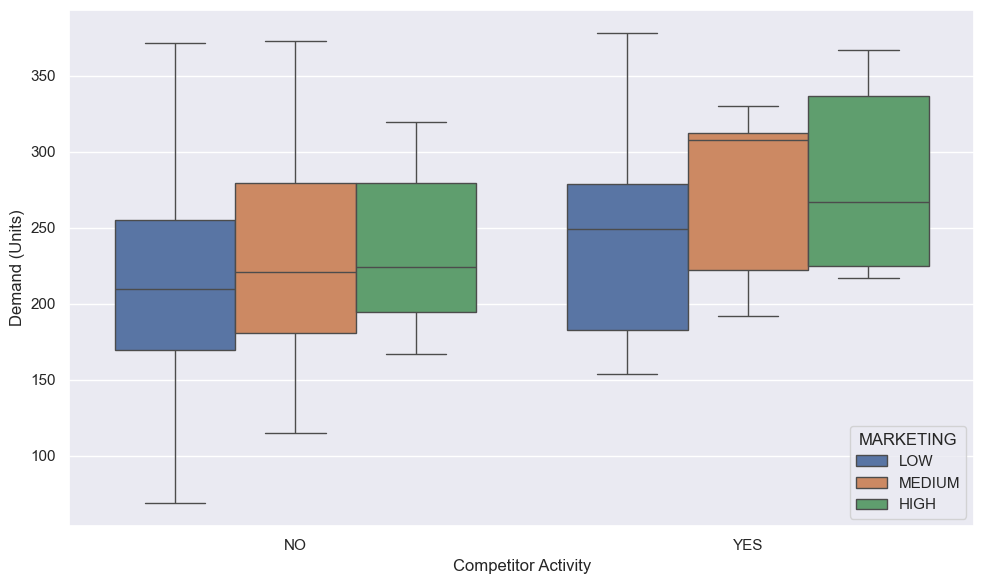

In [19]:
fig = plt.figure(figsize=(10, 6))
ax = sns.boxplot(x="CAF", y="DEMAND", hue="MARKETING", data=transactions)

ax.set_xlabel("Competitor Activity")
ax.set_ylabel("Demand (Units)")

fig.tight_layout()

### Nutritional Trends Index Dataset

In [20]:
nti = pd.read_csv("https://github.com/saschaschworm/big-data-and-data-science/raw/refs/heads/master/datasets/nutritional-trends-index.csv", parse_dates=["RELEASE", "VALID_FROM", "VALID_TO"])

#### Data Dictionary

| **Field Name** | **Data Type** | **Description**                                                                                                                                  |
|----------------|---------------|--------------------------------------------------------------------------------------------------------------------------------------------------|
| `RELEASE`      | `str`         | The release date of the Nutritional Trends Index (NTI) data. This is the date on which the NTI value is published, indicating when the data becomes available. |
| `TARGET`       | `str`         | The month and year for which the NTI is applicable. This field typically contains the abbreviated month name (e.g., "SEP" for September) and refers to the time period that the NTI value represents. |
| `TYPE`         | `str`         | The type of NTI value provided, which is always `ACTUAL`, and refers to the final NTI value observed or recorded for the target month.           |                                                                            
| `VALUE`        | `float`       | The NTI for the specified target month (`TARGET`). This index tracks shifts in consumer preferences, dietary habits, and nutritional awareness over time. |
| `VALID_FROM`   | `str`         | The start date from which the NTI value is considered valid.                                                                                     |
| `VALID_TO`     | `str`         | The end date up to which the NTI value is valid.                                                                                                 |

#### Preliminary Data Analysis

In [21]:
nti

,RELEASE,TARGET,TYPE,VALUE,VALID_FROM,VALID_TO
0,2023-08-01,JUL 2023,ACTUAL,120.0000,2023-07-01,2023-07-31
1,2023-09-01,AUG 2023,ACTUAL,126.0000,2023-08-01,2023-08-31
2,2023-10-01,SEP 2023,ACTUAL,122.0000,2023-09-01,2023-09-30
3,2023-11-01,OCT 2023,ACTUAL,118.0000,2023-10-01,2023-10-31
4,2023-12-01,NOV 2023,ACTUAL,124.0000,2023-11-01,2023-11-30
...,...,...,...,...,...,...
10,2024-06-01,MAY 2024,ACTUAL,130.0000,2024-05-01,2024-05-31
11,2024-07-01,JUN 2024,ACTUAL,171.0000,2024-06-01,2024-06-30
12,2024-08-01,JUL 2024,ACTUAL,132.0000,2024-07-01,2024-07-31
13,2024-09-01,AUG 2024,ACTUAL,138.0000,2024-08-01,2024-08-31


In [22]:
nti.dtypes.to_frame().transpose()

,RELEASE,TARGET,TYPE,VALUE,VALID_FROM,VALID_TO
0,datetime64[ns],object,object,float64,datetime64[ns],datetime64[ns]


In [23]:
nti.describe(include="all")

,RELEASE,TARGET,TYPE,VALUE,VALID_FROM,VALID_TO
count,15,15,15,15.0000,15,15
unique,NaN,15,1,NaN,NaN,NaN
top,NaN,JUL 2023,ACTUAL,NaN,NaN,NaN
freq,NaN,1,15,NaN,NaN,NaN
mean,2024-03-01 14:24:00,NaN,NaN,132.0667,2024-01-31 01:36:00,2024-02-29 14:24:00
min,2023-08-01 00:00:00,NaN,NaN,118.0000,2023-07-01 00:00:00,2023-07-31 00:00:00
25%,2023-11-16 00:00:00,NaN,NaN,123.0000,2023-10-16 12:00:00,2023-11-15 00:00:00
50%,2024-03-01 00:00:00,NaN,NaN,128.0000,2024-02-01 00:00:00,2024-02-29 00:00:00
75%,2024-06-16 00:00:00,NaN,NaN,134.0000,2024-05-16 12:00:00,2024-06-15 00:00:00
max,2024-10-01 00:00:00,NaN,NaN,171.0000,2024-09-01 00:00:00,2024-09-30 00:00:00


#### Exploratory Data Analysis

##### Histogram: Nutritional Trends Index

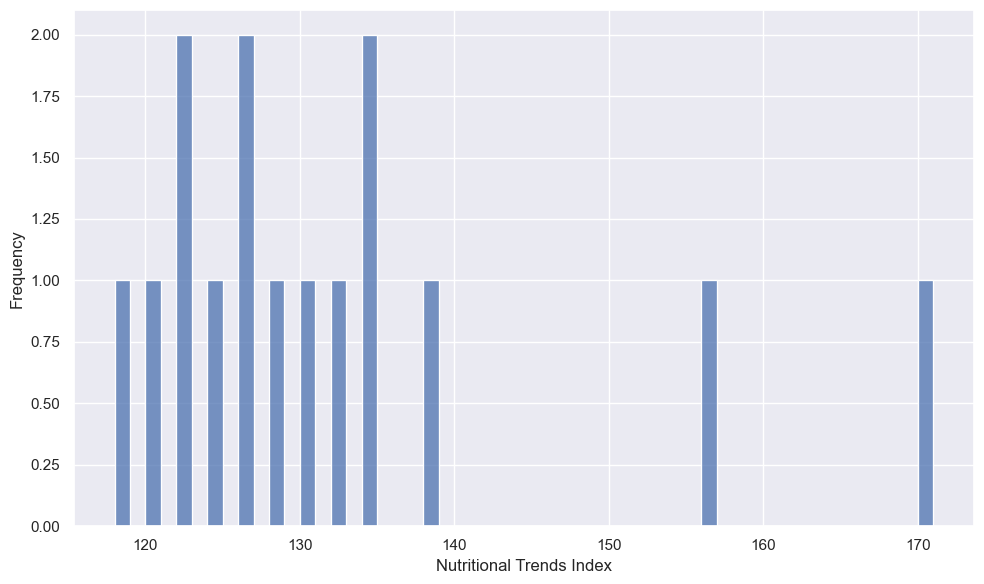

In [24]:
fig = plt.figure(figsize=(10, 6))
ax = sns.histplot(x="VALUE", binwidth=1, data=nti)

ax.set_ylabel("Frequency")
ax.set_xlabel("Nutritional Trends Index")

fig.tight_layout()

##### Line Plot: Nutritional Trends Index

**Exercise:** Create a line plot to examine the Nutritional Trends Index over time by date. At what time do unusual observations occur?

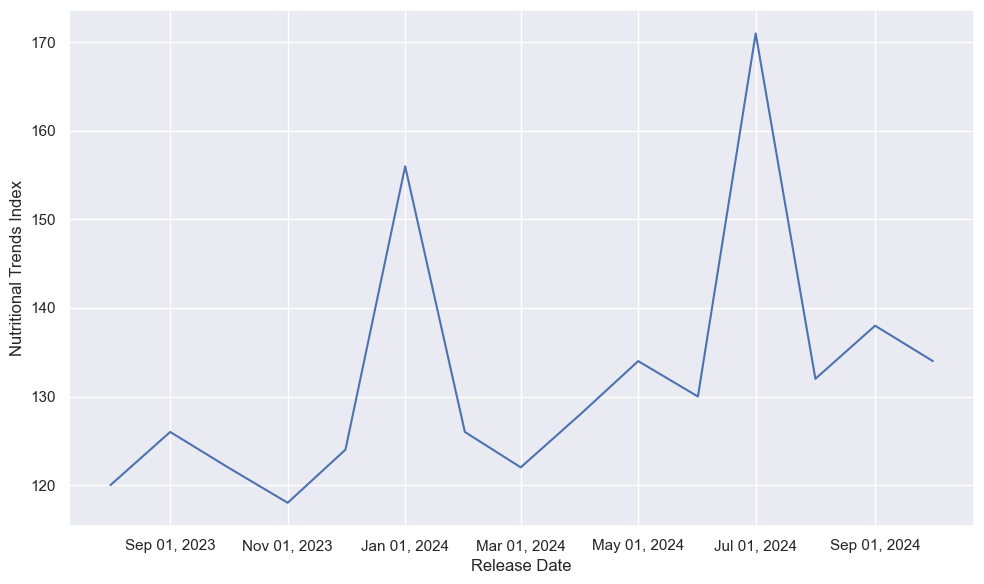

In [25]:
fig = plt.figure(figsize=(10, 6))
ax = sns.lineplot(x="RELEASE", y="VALUE", data=nti)

ax.set_ylabel("Nutritional Trends Index")
ax.set_xlabel("Release Date")

ax.xaxis.set_major_formatter(DateFormatter("%b %d, %Y"))

fig.tight_layout()

### Consumer Climate Index Dataset

In [26]:
cci = pd.read_csv("https://github.com/saschaschworm/big-data-and-data-science/raw/refs/heads/master/datasets/consumer-climate-index.csv", parse_dates=["RELEASE", "VALID_FROM", "VALID_TO"])

#### Data Dictionary

| **Field Name** | **Data Type** | **Description**                                                                                                     |
|----------------|---------------|---------------------------------------------------------------------------------------------------------------------|
| `RELEASE`      | `str`         | The release date of the Consumer Climate Index (CCI) data. This is the date on which the forecast or actual value of the CCI is published. It indicates when the data becomes available to the public or businesses for decision-making. |
| `TARGET`       | `str`         | The month and year for which the CCI is applicable. This field typically contains the abbreviated month name (e.g., "SEP" for September) and refers to the time period that the CCI value represents. |
| `TYPE`         | `str`         | The type of CCI value provided, which can be either `FORECAST` or `ACTUAL`. `FORECAST` indicates a predicted CCI value released before or at the beginning of the target month. `ACTUAL` refers to the final CCI value observed or recorded for the target month. |
| `VALUE`        | `float`       | The value of the CCI for the specified target month (`TARGET`). The CCI is a measure of consumer confidence and sentiment, with negative values indicating pessimism (reduced consumer spending and economic activity) and positive values indicating optimism (increased consumer spending and economic activity). The value is typically expressed as an index relative to a base period. |
| `VALID_FROM`   | `str`         | The start date from which the CCI value is considered valid. For `FORECAST` data, this is typically the first day of the target month (`TARGET`). For `ACTUAL` data, it is the release date (`RELEASE`). |
| `VALID_TO`     | `str`         | The end date up to which the CCI value is valid. For `FORECAST` data, this is typically the last day before the next forecast or actual value is released. For `ACTUAL` data, it is the last day of the target month (`TARGET`). This period defines the coverage of the CCI value in terms of its relevance to economic conditions. |

#### Preliminary Data Analysis

In [27]:
cci

,RELEASE,TARGET,TYPE,VALUE,VALID_FROM,VALID_TO
0,2024-08-27,SEP 2024,FORECAST,-22.0000,2024-09-01,2024-09-30
1,2024-08-27,AUG 2024,ACTUAL,-18.6000,2024-08-27,2024-08-31
2,2024-07-24,AUG 2024,FORECAST,-18.4000,2024-08-01,2024-08-26
3,2024-07-24,JUL 2024,ACTUAL,-21.6000,2024-07-24,2024-07-31
4,2024-06-26,JUL 2024,FORECAST,-21.8000,2024-07-01,2024-07-23
...,...,...,...,...,...,...
53,2022-06-28,JUN 2022,ACTUAL,-26.2000,2022-06-28,2022-06-30
54,2022-05-25,JUN 2022,FORECAST,-26.0000,2022-06-01,2022-06-27
55,2022-05-25,MAY 2022,ACTUAL,-26.6000,2022-05-25,2022-05-31
56,2022-04-27,MAY 2022,FORECAST,-26.5000,2022-05-01,2022-05-24


In [28]:
cci.dtypes.to_frame().transpose()

,RELEASE,TARGET,TYPE,VALUE,VALID_FROM,VALID_TO
0,datetime64[ns],object,object,float64,datetime64[ns],datetime64[ns]


In [29]:
cci.describe(include="all")

,RELEASE,TARGET,TYPE,VALUE,VALID_FROM,VALID_TO
count,58,58,58,58.0000,58,58
unique,NaN,30,2,NaN,NaN,NaN
top,NaN,JUN 2023,FORECAST,NaN,NaN,NaN
freq,NaN,2,29,NaN,NaN,NaN
mean,2023-06-26 10:45:31.034482688,NaN,NaN,-28.5155,2023-06-29 04:08:16.551724032,2023-07-13 11:35:10.344827648
min,2022-04-27 00:00:00,NaN,NaN,-42.8000,2022-04-27 00:00:00,2022-04-30 00:00:00
25%,2022-11-25 00:00:00,NaN,NaN,-30.5750,2022-11-26 12:00:00,2022-12-05 00:00:00
50%,2023-06-28 00:00:00,NaN,NaN,-27.3500,2023-06-29 12:00:00,2023-07-13 00:00:00
75%,2024-01-26 00:00:00,NaN,NaN,-25.1250,2024-01-30 12:00:00,2024-02-19 12:00:00
max,2024-08-27 00:00:00,NaN,NaN,-15.7000,2024-09-01 00:00:00,2024-09-30 00:00:00


### German Public Holidays Dataset

In [30]:
holidays = DataFrame(country_holidays(country="DE", subdiv="NW", years=[2023, 2024]).items(), columns=["DATE", "HOLIDAY"])

#### Data Dictionary

| **Field Name** | **Data Type** | **Description**                                                                                                     |
|----------------|---------------|---------------------------------------------------------------------------------------------------------------------|
| `DATE`         | `str`         | The date of the public holiday in Germany. This field represents the specific day on which the holiday is observed. The date is formatted as `YYYY-MM-DD`. |
| `HOLIDAY`      | `str`         | The name of the public holiday in Germany. This field contains the official name of the holiday in German, such as "Neujahr" (New Year's Day) or "Tag der Deutschen Einheit" (German Unity Day). |

#### Preliminary Data Analysis

In [31]:
holidays

,DATE,HOLIDAY
0,2024-01-01,Neujahr
1,2024-03-29,Karfreitag
2,2024-04-01,Ostermontag
3,2024-05-01,Erster Mai
4,2024-05-09,Christi Himmelfahrt
...,...,...
17,2023-10-03,Tag der Deutschen Einheit
18,2023-12-25,Erster Weihnachtstag
19,2023-12-26,Zweiter Weihnachtstag
20,2023-06-08,Fronleichnam


In [32]:
holidays.dtypes.to_frame().transpose()

,DATE,HOLIDAY
0,object,object


In [33]:
holidays.describe(include="all")

,DATE,HOLIDAY
count,22,22
unique,22,11
top,2024-01-01,Neujahr
freq,1,2


## Data Preparation and Evaluation for Univariate Modeling

### Data Preparation

This phase transforms raw data into a format suitable for modeling, often making it the most time-consuming part of the process. It begins with data integration, where data from multiple sources are combined, such as merging datasets or joining tables. Next, data cleaning addresses issues identified during the previous phase. This includes handling missing values through imputation or removal, correcting outliers, and standardizing formats to resolve inconsistencies. Data transformation follows, performing feature engineering to create new, potentially more predictive features, and modifying the data for modeling by normalizing or standardizing numerical features, encoding categorical variables. Finally, data formatting ensures the data is properly structured and formatted for the modeling tools, including converting data types and ensuring consistent column names.

In [34]:
transformations = make_pipeline(
    SklearnTransformerWrapper(ForwardFillTransformer, variables=["TEMPERATURE"]),
    verbose=False,
)

In [35]:
transactions[["TEMPERATURE"]].transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302
TEMPERATURE,28.1000,28.0000,26.7000,<NA>,25.8000,26.9000,25.9000,25.1000,25.7000,24.3000,22.8000,23.9000,23.4000,22.5000,24.7000,21.1000,22.4000,22.0000,19.6000,21.8000,17.0000,19.1000,17.7000,17.6000,19.5000,16.9000,17.7000,14.4000,15.1000,14.4000,15.7000,11.7000,13.9000,13.0000,12.2000,14.6000,12.2000,11.3000,10.4000,10.5000,8.7000,7.8000,7.6000,7.9000,6.4000,6.6000,6.8000,6.1000,6.1000,3.9000,5.9000,4.6000,5.8000,3.8000,0.2000,0.6000,-0.1000,0.8000,1.6000,-0.8000,0.4000,-1.1000,-2.2000,-1.9000,-0.6000,<NA>,-3.7000,-4.2000,-4.5000,-4.9000,-4.7000,-6.4000,-5.7000,-5.5000,-6.1000,<NA>,-8.0000,-8.1000,-6.5000,-9.3000,-8.0000,-7.5000,-7.6000,-9.5000,-8.3000,-10.3000,-10.0000,-11.8000,-10.9000,-10.8000,-10.3000,-10.5000,-10.9000,-11.7000,-12.2000,-12.4000,-14.9000,-15.6000,-14.5000,-15.3000,-13.1000,-14.9000,-13.6000,-13.8000,-15.1000,-13.2000,-14.0000,-15.5000,-12.3000,-17.1000,-15.8000,-14.8000,-13.6000,-15.6000,-17.8000,-14.9000,-14.2000,-14.7000,-14.5000,-14.8000,-15.1000,-14.7000,-13.7000,-15.6000,-14.9000,-14.2000,-14.4000,-13.7000,-14.1000,-13.9000,-14.6000,-11.9000,-11.7000,-12.2000,-13.5000,-13.2000,-12.5000,-10.8000,-10.6000,-12.2000,-12.2000,-11.3000,<NA>,-12.0000,-11.9000,-11.5000,-9.8000,-10.3000,-9.7000,-10.5000,-8.6000,-9.6000,-6.1000,-7.4000,<NA>,-6.9000,-5.9000,-6.0000,-7.5000,-4.9000,-6.0000,-5.1000,-5.0000,-3.4000,-3.6000,-3.7000,-0.4000,-1.8000,-1.9000,0.2000,1.0000,0.5000,0.4000,0.6000,1.0000,<NA>,3.3000,5.8000,5.5000,4.4000,6.3000,7.1000,5.7000,7.6000,8.6000,6.8000,7.0000,8.8000,9.7000,9.7000,11.5000,10.6000,12.0000,12.3000,12.4000,13.3000,13.4000,13.8000,14.5000,15.0000,<NA>,17.1000,14.9000,16.9000,18.1000,17.7000,18.5000,19.6000,20.3000,20.6000,18.7000,20.5000,22.2000,22.3000,21.3000,23.2000,25.8000,23.9000,25.5000,26.3000,25.4000,26.5000,26.3000,27.0000,29.1000,26.8000,26.3000,28.3000,30.6000,30.9000,28.9000,28.3000,29.1000,30.0000,30.1000,<NA>,30.7000,32.3000,31.1000,31.5000,32.7000,32.7000,31.6000,31.2000,33.3000,33.5000,33.5000,33.5000,33.8000,36.6000,35.1000,35.5000,34.3000,35.2000,34.2000,35.2000,34.2000,34.4000,35.1000,36.3000,35.7000,34.7000,34.8000,36.5000,36.0000,35.3000,35.7000,34.0000,34.5000,34.9000,35.9000,35.3000,35.0000,33.3000,34.2000,36.1000,33.7000,34.8000,35.0000,32.8000,34.8000,35.5000,32.6000,33.1000,31.2000,31.2000,31.2000,32.7000,32.7000,31.2000,32.7000,31.1000,32.8000,30.9000,28.0000,31.4000,29.4000,28.7000,27.7000,29.5000,28.3000,28.4000,27.7000


In [36]:
transactions[["TEMPERATURE"]].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
TEMPERATURE,295.0000,10.3403,17.8923,-17.8000,-7.5000,10.6000,28.0500,36.6000


In [37]:
transformations.fit_transform(transactions[["TEMPERATURE"]]).transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302
TEMPERATURE,28.1000,28.0000,26.7000,26.7000,25.8000,26.9000,25.9000,25.1000,25.7000,24.3000,22.8000,23.9000,23.4000,22.5000,24.7000,21.1000,22.4000,22.0000,19.6000,21.8000,17.0000,19.1000,17.7000,17.6000,19.5000,16.9000,17.7000,14.4000,15.1000,14.4000,15.7000,11.7000,13.9000,13.0000,12.2000,14.6000,12.2000,11.3000,10.4000,10.5000,8.7000,7.8000,7.6000,7.9000,6.4000,6.6000,6.8000,6.1000,6.1000,3.9000,5.9000,4.6000,5.8000,3.8000,0.2000,0.6000,-0.1000,0.8000,1.6000,-0.8000,0.4000,-1.1000,-2.2000,-1.9000,-0.6000,-0.6000,-3.7000,-4.2000,-4.5000,-4.9000,-4.7000,-6.4000,-5.7000,-5.5000,-6.1000,-6.1000,-8.0000,-8.1000,-6.5000,-9.3000,-8.0000,-7.5000,-7.6000,-9.5000,-8.3000,-10.3000,-10.0000,-11.8000,-10.9000,-10.8000,-10.3000,-10.5000,-10.9000,-11.7000,-12.2000,-12.4000,-14.9000,-15.6000,-14.5000,-15.3000,-13.1000,-14.9000,-13.6000,-13.8000,-15.1000,-13.2000,-14.0000,-15.5000,-12.3000,-17.1000,-15.8000,-14.8000,-13.6000,-15.6000,-17.8000,-14.9000,-14.2000,-14.7000,-14.5000,-14.8000,-15.1000,-14.7000,-13.7000,-15.6000,-14.9000,-14.2000,-14.4000,-13.7000,-14.1000,-13.9000,-14.6000,-11.9000,-11.7000,-12.2000,-13.5000,-13.2000,-12.5000,-10.8000,-10.6000,-12.2000,-12.2000,-11.3000,-11.3000,-12.0000,-11.9000,-11.5000,-9.8000,-10.3000,-9.7000,-10.5000,-8.6000,-9.6000,-6.1000,-7.4000,-7.4000,-6.9000,-5.9000,-6.0000,-7.5000,-4.9000,-6.0000,-5.1000,-5.0000,-3.4000,-3.6000,-3.7000,-0.4000,-1.8000,-1.9000,0.2000,1.0000,0.5000,0.4000,0.6000,1.0000,1.0000,3.3000,5.8000,5.5000,4.4000,6.3000,7.1000,5.7000,7.6000,8.6000,6.8000,7.0000,8.8000,9.7000,9.7000,11.5000,10.6000,12.0000,12.3000,12.4000,13.3000,13.4000,13.8000,14.5000,15.0000,15.0000,17.1000,14.9000,16.9000,18.1000,17.7000,18.5000,19.6000,20.3000,20.6000,18.7000,20.5000,22.2000,22.3000,21.3000,23.2000,25.8000,23.9000,25.5000,26.3000,25.4000,26.5000,26.3000,27.0000,29.1000,26.8000,26.3000,28.3000,30.6000,30.9000,28.9000,28.3000,29.1000,30.0000,30.1000,30.1000,30.7000,32.3000,31.1000,31.5000,32.7000,32.7000,31.6000,31.2000,33.3000,33.5000,33.5000,33.5000,33.8000,36.6000,35.1000,35.5000,34.3000,35.2000,34.2000,35.2000,34.2000,34.4000,35.1000,36.3000,35.7000,34.7000,34.8000,36.5000,36.0000,35.3000,35.7000,34.0000,34.5000,34.9000,35.9000,35.3000,35.0000,33.3000,34.2000,36.1000,33.7000,34.8000,35.0000,32.8000,34.8000,35.5000,32.6000,33.1000,31.2000,31.2000,31.2000,32.7000,32.7000,31.2000,32.7000,31.1000,32.8000,30.9000,28.0000,31.4000,29.4000,28.7000,27.7000,29.5000,28.3000,28.4000,27.7000


In [38]:
transformations.fit_transform(transactions[["TEMPERATURE"]]).describe().transpose()

,count,mean,std,min,25%,50%,75%,max
TEMPERATURE,303.0000,10.2238,17.8344,-17.8000,-7.4500,10.5000,28.0000,36.6000


### Modeling

This phase involves selecting and applying algorithms to the prepared data to create predictive models. This phase requires careful selection of model types and parameters, as different models may be better suited to the specific data and problem. Multiple models are typically built and tested to identify the best performer. The process includes splitting the data into training and testing sets, training the models on the training data, and fine-tuning them by adjusting hyperparameters to optimize performance. The goal is to develop a model that accurately captures underlying patterns and generalizes well to new, unseen data.

In [39]:
model = make_pipeline(
    transformations,
    SGDRegressor(penalty=None, alpha=0.0001, max_iter=1000, tol=0.001, shuffle=True, verbose=0, random_state=1207, 
        learning_rate="invscaling", eta0=0.001, power_t=0.25, n_iter_no_change=5,
    ),
    verbose=False,
).fit(transactions[["TEMPERATURE"]], transactions["DEMAND"])

In [40]:
DataFrame([[model[-1].intercept_[0], *model[-1].coef_]], columns=["INTERCEPT", "TEMPERATURE"])

,INTERCEPT,TEMPERATURE
0,184.9436,3.1543


In [41]:
predictions = transactions[["ODATE", "TDATE", "DEMAND", "TEMPERATURE", "PPRC", "RPRC", "UGP"]].copy()
predictions["YHAT"] = model.predict(transactions[["TEMPERATURE"]])
predictions["PQTY"] = np.ceil(predictions["YHAT"])
predictions = predictions.merge(get_inventory_metrics(predictions), left_index=True, right_index=True)
predictions

,ODATE,TDATE,DEMAND,TEMPERATURE,PPRC,RPRC,UGP,YHAT,PQTY,PC,GP,INVENTORY,CEI,CLS,NP,SQTY,SR
0,2023-08-31,2023-09-01,218,28.1000,3.1800,3.9900,0.8100,273.5789,274.0000,871.3200,-1.5000,56.0000,178.0800,0.0000,-1.5000,218.0000,869.8200
1,2023-09-01,2023-09-02,240,28.0000,3.1200,3.9900,0.8700,273.2634,274.0000,854.8800,102.7200,34.0000,106.0800,0.0000,102.7200,240.0000,957.6000
2,2023-09-02,2023-09-04,177,26.7000,3.1800,3.8900,0.7100,269.1629,270.0000,858.6000,-170.0700,93.0000,295.7400,0.0000,-170.0700,177.0000,688.5300
3,2023-09-04,2023-09-05,199,<NA>,2.8000,3.3900,0.5900,269.1629,270.0000,756.0000,-81.3900,71.0000,198.8000,0.0000,-81.3900,199.0000,674.6100
4,2023-09-05,2023-09-06,154,25.8000,3.1800,3.9900,0.8100,266.3240,267.0000,849.0600,-234.6000,113.0000,359.3400,0.0000,-234.6000,154.0000,614.4600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,2024-08-26,2024-08-27,314,27.7000,2.0000,2.5900,0.5900,272.3171,273.0000,546.0000,161.0700,-41.0000,0.0000,24.1900,136.8800,273.0000,707.0700
299,2024-08-27,2024-08-28,278,29.5000,2.0800,2.6900,0.6100,277.9948,278.0000,578.2400,169.5800,0.0000,0.0000,0.0000,169.5800,278.0000,747.8200
300,2024-08-28,2024-08-29,337,28.3000,1.9700,2.4900,0.5200,274.2097,275.0000,541.7500,143.0000,-62.0000,0.0000,32.2400,110.7600,275.0000,684.7500
301,2024-08-29,2024-08-30,330,28.4000,1.9100,2.3900,0.4800,274.5251,275.0000,525.2500,132.0000,-55.0000,0.0000,26.4000,105.6000,275.0000,657.2500


In [42]:
forecast = DataFrame({"TDATE": pd.date_range("2024-09-01", periods=7), "TEMPERATURE": [27, 28, 29, 28, 28, 27, 27]})
forecast["FORECAST"] = model.predict(forecast[["TEMPERATURE"]])
forecast

,TDATE,TEMPERATURE,FORECAST
0,2024-09-01,27,270.1091
1,2024-09-02,28,273.2634
2,2024-09-03,29,276.4177
3,2024-09-04,28,273.2634
4,2024-09-05,28,273.2634
5,2024-09-06,27,270.1091
6,2024-09-07,27,270.1091


### Evaluation

This phase assesses the performance of the models developed during the Modeling phase to ensure they meet the project's objectives. This involves testing the models on the test data and evaluating them with relevant metrics, such as accuracy, precision, recall, F1-score, or mean squared error, depending on the problem type (classification, regression, etc.). The process also includes validating the model's robustness and consistency across different data subsets, often using cross-validation techniques to ensure reliability. The goal is to identify the most effective model that strikes the best balance between performance and generalization.

In [43]:
print(f"RMSE (History): {root_mean_squared_error(transactions["DEMAND"], transactions["PQTY"]):,.2f} UNITS")
print(f"RMSE (Model): {root_mean_squared_error(transactions["DEMAND"], predictions["PQTY"]):,.2f} UNITS")

RMSE (History): 46.61 UNITS
RMSE (Model): 49.28 UNITS


In [44]:
metrics = pd.merge(get_business_metrics(transactions), get_business_metrics(predictions), on=["KPI", "DESCRIPTION"])
metrics = metrics.rename({"VALUE_x": "BENCHMARK", "VALUE_y": "SLR"}, axis=1)
metrics

,KPI,DESCRIPTION,BENCHMARK,SLR
0,Root Mean Squared Error,Measures the average difference between actual demand and purchased quantity.,46.61 UNITS,49.28 UNITS
1,Total Cost of Inefficiency,The combined cost of excess inventory and lost sales.,"30,720.14 EUR","20,899.78 EUR"
2,Total Sales Revenue,Total revenue generated from sales.,"241,249.54 EUR","220,316.95 EUR"
3,Total Purchase Cost,Total cost incurred from purchasing goods.,"220,783.34 EUR","190,030.39 EUR"
4,Total Gross Profit,Total profit before accounting for overhead costs.,"20,466.20 EUR","30,286.56 EUR"
5,Total Net Profit,Total profit after all expenses have been deducted.,"18,932.63 EUR","24,525.28 EUR"
6,Total Waste Rate,Percentage of inventory left over (waste) compared to total purchased quantity.,12.39 %,7.67 %
7,Total Waste Quantity,Total number of units left as waste.,9293 UNITS,5056.0 UNITS
8,Overstock Rate,Percentage of records where there is excess inventory.,76.57 %,45.87 %
9,Understock Rate,Percentage of records where there is a shortage of inventory.,23.10 %,52.15 %


#### Holdout Method

In [45]:
X_train, X_test, y_train, y_test = train_test_split(
    transactions[["TEMPERATURE"]], transactions["DEMAND"], test_size=0.25, shuffle=True, random_state=1207,
)

In [46]:
X_train.merge(y_train, left_index=True, right_index=True).transpose()

,8,198,163,47,246,176,221,114,116,260,98,0,16,81,96,288,120,242,194,29,68,54,2,250,147,173,207,17,23,49,216,294,219,109,169,70,244,223,222,136,124,85,37,144,165,28,214,74,261,159,259,105,128,281,193,31,154,185,236,266,264,211,206,41,296,36,112,75,113,220,227,202,53,156,115,90,78,268,254,93,62,157,158,139,195,106,240,55,181,283,168,133,208,257,174,224,161,186,279,150,110,26,134,256,275,30,162,286,103,89,205,142,79,190,271,196,86,77,107,232,247,137,40,88,80,231,146,20,213,141,229,129,274,67,27,12,87,183,265,92,270,111,272,104,19,276,149,125,101,215,5,52,126,130,84,245,238,99,295,71,289,212,64,22,9,184,255,164,273,50,39,160,241,291,63,66,263,171,34,57,42,243,127,292,132,122,56,258,94,123,95,60,11,201,187,285,140,218,155,253,38,148,200,143,182,302,284,170,249,119,151,51,7,301,189,180,6,204,172,293,100,300,298,44,177,58,135
TEMPERATURE,25.7000,14.5000,-3.4000,6.1000,33.5000,3.3000,26.5000,-17.8000,-14.2000,35.7000,-14.5000,28.1000,22.4000,-7.5000,-14.9000,32.7000,-15.1000,31.6000,12.4000,14.4000,-4.5000,0.2000,26.7000,35.1000,-10.3000,0.6000,19.6000,22.0000,17.6000,3.9000,25.8000,28.0000,26.3000,-17.1000,0.2000,-4.7000,33.3000,27.0000,26.3000,-12.5000,-14.9000,-10.3000,11.3000,-11.9000,-3.7000,15.1000,21.3000,-6.1000,34.7000,-4.9000,36.3000,-13.2000,-14.1000,35.5000,12.3000,11.7000,<NA>,6.8000,30.7000,35.7000,36.0000,20.5000,18.5000,7.8000,29.4000,12.2000,-13.6000,<NA>,-15.6000,25.4000,28.3000,14.9000,3.8000,-5.9000,-14.9000,-10.3000,-6.5000,34.5000,34.2000,-11.7000,-2.2000,-6.0000,-7.5000,-12.2000,13.3000,-14.0000,32.7000,0.6000,7.1000,33.1000,-1.9000,-12.2000,20.3000,34.4000,1.0000,29.1000,-5.1000,7.0000,32.8000,-8.6000,-15.8000,17.7000,-13.5000,34.2000,36.1000,15.7000,-5.0000,31.2000,-13.8000,-10.8000,17.7000,<NA>,-9.3000,11.5000,35.3000,13.4000,-10.0000,-8.1000,-15.5000,29.1000,33.5000,-10.8000,8.7000,-10.9000,-8.0000,28.3000,-9.8000,17.0000,22.3000,-11.3000,30.9000,-13.9000,34.2000,-4.2000,14.4000,23.4000,-11.8000,7.6000,35.3000,-10.9000,35.9000,-14.8000,35.0000,-15.1000,21.8000,33.7000,-10.5000,-14.2000,-14.9000,23.2000,26.9000,5.8000,-14.4000,-14.6000,-8.3000,33.5000,31.1000,-15.3000,31.4000,-6.4000,31.2000,22.2000,-0.6000,17.7000,24.3000,8.6000,35.2000,-3.6000,33.3000,5.9000,10.5000,-6.0000,32.7000,31.1000,-1.9000,-3.7000,36.5000,0.5000,12.2000,0.8000,7.6000,31.2000,-13.7000,32.8000,-11.7000,-13.7000,-0.1000,35.1000,-12.2000,-15.6000,-12.4000,0.4000,23.9000,17.1000,8.8000,31.2000,-12.2000,25.5000,-6.9000,35.2000,10.4000,-9.7000,<NA>,-12.0000,5.7000,27.7000,31.2000,1.0000,36.6000,-14.8000,-9.6000,4.6000,25.1000,28.4000,9.7000,6.3000,25.9000,18.1000,0.4000,30.9000,-13.1000,28.3000,27.7000,6.4000,5.8000,1.6000,-13.2000
DEMAND,168,239,208,217,250,219,207,196,221,323,204,218,159,183,139,309,154,314,185,278,171,174,177,269,97,158,246,175,203,207,167,279,277,218,204,225,284,316,212,131,232,150,183,112,180,200,328,150,281,170,285,170,227,262,153,190,290,221,326,322,257,193,280,225,372,250,195,200,168,201,273,256,259,194,206,116,152,254,339,128,163,230,318,179,145,247,255,205,192,329,144,178,292,254,238,331,159,259,323,125,225,258,191,279,244,258,175,316,206,226,238,135,167,201,311,159,102,224,154,277,292,115,189,151,145,255,202,159,213,110,307,125,281,175,177,223,173,214,276,107,292,167,306,251,252,309,107,158,163,238,194,211,157,165,129,242,279,291,344,235,367,192,206,176,181,216,258,228,271,252,192,216,277,290,190,145,248,174,182,198,249,244,215,318,129,290,162,284,179,159,311,169,178,234,167,279,193,227,180,318,181,188,261,69,212,378,363,214,294,156,217,208,267,330,156,283,217,213,219,270,212,337,314,180,164,202,124


In [47]:
X_test.merge(y_test, left_index=True, right_index=True).transpose()

,153,252,108,121,287,267,226,278,97,18,167,239,102,166,280,4,269,1,179,235,248,299,61,91,228,117,24,83,178,131,25,262,73,251,145,65,69,233,3,282,152,234,175,217,118,277,43,32,33,13,138,192,76,203,15,297,225,35,82,191,21,14,230,209,46,45,48,237,197,59,10,210,199,290,188,72
TEMPERATURE,-7.4000,34.3000,-12.3000,-14.7000,32.7000,34.0000,26.3000,35.0000,-15.6000,19.6000,-1.8000,31.5000,-13.6000,-0.4000,34.8000,25.8000,34.9000,28.0000,4.4000,<NA>,33.8000,29.5000,-1.1000,-10.5000,30.6000,-14.7000,19.5000,-9.5000,5.5000,-11.9000,16.9000,34.8000,-5.5000,35.5000,-11.5000,<NA>,-4.9000,30.0000,<NA>,32.6000,-6.1000,30.1000,<NA>,23.9000,-14.5000,34.8000,7.9000,13.9000,13.0000,22.5000,-10.6000,12.0000,-8.0000,16.9000,21.1000,28.7000,26.8000,14.6000,-7.6000,10.6000,19.1000,24.7000,28.9000,20.6000,6.8000,6.6000,6.1000,32.3000,13.8000,-0.8000,22.8000,18.7000,15.0000,32.7000,9.7000,-5.7000
DEMAND,162,288,195,207,275,246,297,366,199,208,164,252,181,186,329,154,215,240,222,304,373,278,196,149,266,170,237,232,228,116,320,263,237,289,190,222,201,223,199,303,284,255,278,229,188,360,193,234,194,244,145,212,189,287,193,307,277,186,185,233,230,203,335,197,185,143,296,253,220,242,158,263,159,377,187,181


In [48]:
model = model.fit(X_train, y_train)

In [49]:
print(f"RMSE (Training Set): {root_mean_squared_error(y_train, model.predict(X_train)):,.2f} UNITS")
print(f"RMSE (Test Set): {root_mean_squared_error(y_test, model.predict(X_test)):,.2f} UNITS")

RMSE (Training Set): 49.10 UNITS
RMSE (Test Set): 49.58 UNITS


#### K-Fold Cross-Validation

In [50]:
kfold = KFold(n_splits=10, shuffle=False)
evaluation = cross_validate(
    estimator=model, X=transactions[["TEMPERATURE"]], y=transactions["DEMAND"], cv=kfold, n_jobs=-1, 
    scoring="neg_root_mean_squared_error", verbose=0, return_train_score=True,
)
cv = DataFrame(evaluation)

In [51]:
cv.transpose()

,0,1,2,3,4,5,6,7,8,9
fit_time,0.0040,0.0088,0.0054,0.0087,0.0094,0.0117,0.0042,0.0103,0.0049,0.0093
score_time,0.0011,0.0038,0.0011,0.0014,0.0023,0.0014,0.0015,0.0015,0.0017,0.0041
test_score,-58.9269,-34.4251,-39.1538,-76.2719,-47.6504,-52.1565,-41.8622,-41.4426,-36.5324,-72.7534
train_score,-46.2616,-49.8006,-50.8065,-45.8306,-47.7227,-49.2155,-48.7516,-48.5431,-49.0316,-44.9650


In [52]:
cv.agg("mean").to_frame().transpose()

,fit_time,score_time,test_score,train_score
0,0.0077,0.0020,-50.1175,-48.0929


**Exercise:** Conduct a $k$-fold cross-validation analysis while varying the value of k. What observations can you make regarding the model’s performance as you change $k$?

#### Time-Series Cross-Validation

In [53]:
tscv = TimeSeriesSplit(n_splits=10, gap=1)
evaluation = cross_validate(
    estimator=model, X=transactions[["TEMPERATURE"]], y=transactions["DEMAND"], cv=tscv, n_jobs=-1, 
    scoring="neg_root_mean_squared_error", verbose=0, return_train_score=True,
)
cv = DataFrame(evaluation)

In [54]:
cv.transpose()

,0,1,2,3,4,5,6,7,8,9
fit_time,0.0027,0.0033,0.0053,0.0090,0.0038,0.0028,0.0075,0.0037,0.0028,0.0043
score_time,0.0010,0.0024,0.0035,0.0033,0.0010,0.0010,0.0020,0.0036,0.0033,0.0027
test_score,-152.6472,-212.2243,-56.6972,-41.4845,-57.3449,-39.2933,-49.7188,-62.4952,-45.3324,-77.1056
train_score,-63.7220,-97.2861,-38.0291,-41.8038,-41.6148,-44.1821,-43.3236,-43.7478,-45.2730,-44.9160


In [55]:
cv.agg("mean").to_frame().transpose()

,fit_time,score_time,test_score,train_score
0,0.0045,0.0024,-79.4343,-50.3898


### Data Preparation, Modeling, and Evaluation (Part II)

In [56]:
model = make_pipeline(
    SklearnTransformerWrapper(ForwardFillTransformer, variables=["TEMPERATURE"]),
    SklearnTransformerWrapper(PolynomialFeatures(degree=2, include_bias=False)),
    SGDRegressor(penalty=None, alpha=0.0001, max_iter=1000, tol=0.001, shuffle=True, verbose=0, random_state=1207, 
        learning_rate="invscaling", eta0=0.001, power_t=0.25, n_iter_no_change=5,
    ),
    verbose=False,
).fit(transactions[["TEMPERATURE"]], transactions["DEMAND"])

In [57]:
DataFrame([[model[-1].intercept_[0], *model[-1].coef_]], columns=["INTERCEPT", *model[:-1].get_feature_names_out()])

,INTERCEPT,TEMPERATURE,TEMPERATURE^2
0,"33,025,907,068.4662","18,238,746,315.8317","5,437,642,015.6245"


### Data Preparation, Modeling, and Evaluation (Part III)

In [58]:
model = make_pipeline(
    SklearnTransformerWrapper(ForwardFillTransformer, variables=["TEMPERATURE"]),
    SklearnTransformerWrapper(PolynomialFeatures(degree=2, include_bias=False)),
    SklearnTransformerWrapper(StandardScaler()),
    SGDRegressor(penalty=None, alpha=0.0001, max_iter=1000, tol=0.001, shuffle=True, verbose=0, random_state=1207, 
        learning_rate="invscaling", eta0=0.1, power_t=0.25, n_iter_no_change=5,
    ),
    verbose=False,
).fit(transactions[["TEMPERATURE"]], transactions["DEMAND"])

In [59]:
DataFrame(
    data=[[model[-1].intercept_[0], *model[-1].coef_]],
    columns=["INTERCEPT", *model[:-1].get_feature_names_out()],
)

,INTERCEPT,TEMPERATURE,TEMPERATURE^2
0,220.3359,19.7189,21.0290


In [60]:
tscv = TimeSeriesSplit(n_splits=10, gap=1)
evaluation = cross_validate(
    estimator=model, X=transactions[["TEMPERATURE"]], y=transactions["DEMAND"], cv=tscv, n_jobs=-1, 
    scoring="neg_root_mean_squared_error", verbose=0, return_train_score=True,
)
cv = DataFrame(evaluation)

In [61]:
cv.transpose()

,0,1,2,3,4,5,6,7,8,9
fit_time,0.0056,0.0087,0.0083,0.0091,0.0115,0.0103,0.0120,0.0069,0.0057,0.0064
score_time,0.0025,0.0065,0.0029,0.0025,0.0048,0.0025,0.0031,0.0024,0.0023,0.0050
test_score,-42.2975,-33.6935,-58.8028,-43.1649,-57.4630,-35.7092,-47.9286,-89.6393,-28.0657,-68.3533
train_score,-38.8295,-36.3441,-34.7550,-39.8931,-40.4384,-43.5503,-42.6048,-43.3688,-43.6945,-42.7579


In [62]:
cv.agg("mean").to_frame().transpose()

,fit_time,score_time,test_score,train_score
0,0.0085,0.0034,-50.5118,-40.6236


**Exercise:** Experiment with different polynomial degrees to determine the best fit for your model. Then, apply a high polynomial degree while varying the L1 (`penalty = "l1"`) and L2 (`penalty = "l2"`) regularization rates. What do you notice about the coefficients as you change the regularization rate and learning rate?

### Data Preparation, Modeling, and Evaluation (Part IV)

In [63]:
stats.randint(1, 11).rvs(size=1)

array([1])

In [64]:
params = {
    "sklearntransformerwrapper-2__transformer__degree": stats.randint(1, 11),
    "sgdregressor__alpha": stats.loguniform(0.0001, 0.1),
    "sgdregressor__max_iter": stats.randint(1000, 3001),
    "sgdregressor__eta0": stats.loguniform(0.0001, 0.1),
    "sgdregressor__penalty": ["l2", "l1", None],
}

In [65]:
X_train, X_test, y_train, y_test = train_test_split(transactions[["TEMPERATURE"]], transactions["DEMAND"], shuffle=False)
tscv = TimeSeriesSplit(n_splits=10, gap=1)

evaluation = RandomizedSearchCV(
    estimator=model, param_distributions=params, n_iter=10, scoring="neg_root_mean_squared_error", cv=tscv, 
    random_state=1207, n_jobs=-1, return_train_score=True, verbose=0,
)

evaluation = evaluation.fit(X_train, y_train)
cv = DataFrame(evaluation.cv_results_)

/Users/saschaschworm/Documents/Veranstaltungsunterlagen/big-data-and-data-science/.venv/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/saschaschworm/Documents/Veranstaltungsunterlagen/big-data-and-data-science/.venv/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/saschaschworm/Documents/Veranstaltungsunterlagen/big-data-and-data-science/.venv/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/saschaschworm/Documents/Veranstaltungsunterlagen/big-data-and-d

In [66]:
cv.drop("params", axis=1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_sgdregressor__alpha,param_sgdregressor__eta0,param_sgdregressor__max_iter,param_sgdregressor__penalty,param_sklearntransformerwrapper-2__transformer__degree,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.0197,0.0174,0.0076,0.0108,0.0230,0.0127,2713,l2,2,-40.4799,-34.3515,-36.6627,-59.9406,-35.7660,-55.7062,-55.4972,-37.2790,-42.5853,-59.8711,-45.8140,10.0827,2,-38.2248,-36.7432,-35.4304,-34.7772,-40.1635,-39.6923,-41.7055,-43.5811,-42.7252,-42.5905,-39.5634,3.0000
1,0.0116,0.0143,0.0082,0.0076,0.0279,0.0454,2030,l1,5,-45.4248,-36.0063,-37.5187,-56.1718,-34.6815,-52.6881,-56.7983,-37.0669,-42.8428,-75.7889,-47.4988,12.3277,6,-37.9250,-36.5549,-35.4517,-34.9576,-39.6798,-39.1500,-41.0467,-43.3520,-42.1063,-42.7167,-39.2941,2.8684
2,0.0259,0.0256,0.0116,0.0084,0.0014,0.0049,1570,l1,8,-56.4113,-35.4252,-38.5304,-57.4308,-34.7814,-55.2842,-57.4797,-37.5226,-43.5251,-63.6035,-47.9994,10.4805,8,-37.4055,-36.5450,-35.3987,-34.7358,-39.7135,-39.2858,-40.4357,-43.3948,-41.9786,-42.2392,-39.1133,2.8447
3,0.0724,0.0436,0.0147,0.0190,0.0002,0.0008,2912,l1,7,-47.5430,-35.3800,-38.4173,-57.4498,-34.6723,-54.6899,-56.9506,-36.5663,-42.9714,-63.5986,-46.8239,10.1420,5,-37.7488,-36.6334,-35.4345,-34.7935,-39.6303,-39.1028,-40.8559,-43.0790,-42.1296,-42.1254,-39.1533,2.7819
4,0.0680,0.0441,0.0099,0.0087,0.0017,0.0001,2917,None,9,-100.2949,-86.8052,-50.4389,-68.5548,-48.7313,-43.7556,-61.7669,-46.1306,-44.0369,-69.7833,-62.0298,18.4458,10,-114.9555,-85.7973,-67.5254,-55.0829,-51.2376,-46.6368,-45.6758,-46.0666,-44.3737,-43.6430,-60.0995,22.2098
5,0.0067,0.0030,0.0036,0.0020,0.0006,0.0628,2277,l2,4,-43.8813,-37.0709,-36.6757,-56.9117,-34.6066,-51.7944,-56.9450,-36.8385,-43.3795,-63.4458,-46.1549,9.8403,4,-38.0450,-36.4742,-35.4189,-34.9650,-39.5493,-39.0891,-40.9439,-43.3071,-41.9894,-41.9714,-39.1753,2.7658
6,0.0074,0.0026,0.0031,0.0014,0.0007,0.0834,2994,l2,2,-38.7618,-33.9215,-35.5336,-62.8718,-37.8790,-55.1536,-55.1948,-36.8110,-42.7585,-60.8189,-45.9705,10.6832,3,-38.2368,-36.6955,-35.3696,-34.7458,-40.4133,-39.7178,-41.7413,-43.6604,-42.7466,-42.5957,-39.5923,3.0393
7,0.0068,0.0033,0.0036,0.0017,0.0002,0.0814,2596,l1,4,-48.9759,-37.5752,-36.3146,-56.8511,-34.8253,-50.4267,-57.4883,-36.7504,-43.6275,-79.2477,-48.2083,13.0983,9,-38.0276,-36.4864,-35.4321,-35.1922,-39.4631,-39.1783,-40.9285,-43.3686,-41.9053,-43.2495,-39.3232,2.8809
8,0.0172,0.0082,0.0040,0.0016,0.0192,0.0013,1970,None,9,-55.9509,-35.5032,-37.7092,-58.2097,-34.6130,-54.3919,-57.1801,-36.1212,-43.6842,-62.0938,-47.5457,10.4411,7,-37.3348,-36.4163,-35.2536,-34.6047,-39.4010,-38.8959,-40.5853,-42.9020,-41.9473,-42.0047,-38.9346,2.7997
9,0.0230,0.0098,0.0046,0.0017,0.0678,0.0005,2842,l1,5,-36.1288,-35.3782,-39.2631,-56.2275,-34.8777,-55.0920,-56.5207,-36.8907,-42.3307,-64.3168,-45.7026,10.5279,1,-39.6784,-36.7662,-35.4982,-34.8981,-39.7669,-39.2302,-41.1099,-43.2697,-42.3747,-42.2932,-39.4885,2.7876


In [67]:
cv[["mean_train_score", "std_train_score", "mean_test_score", "std_test_score"]].agg("mean").to_frame().transpose()

,mean_train_score,std_train_score,mean_test_score,std_test_score
0,-41.3737,4.7978,-48.3748,11.6070


In [68]:
DataFrame([evaluation.best_params_])

,sgdregressor__alpha,sgdregressor__eta0,sgdregressor__max_iter,sgdregressor__penalty,sklearntransformerwrapper-2__transformer__degree
0,0.0678,0.0005,2842,l1,5


In [69]:
evaluation.best_estimator_[:-1]

Pipeline(steps=[('sklearntransformerwrapper-1',
                 SklearnTransformerWrapper(transformer=FunctionTransformer(func=<function <lambda> at 0x173c2f100>),
                                           variables=['TEMPERATURE'])),
                ('sklearntransformerwrapper-2',
                 SklearnTransformerWrapper(transformer=PolynomialFeatures(degree=5,
                                                                          include_bias=False))),
                ('sklearntransformerwrapper-3',
                 SklearnTransformerWrapper(transformer=StandardScaler()))])

In [70]:
DataFrame(
    data=[[evaluation.best_estimator_[-1].intercept_[0], *evaluation.best_estimator_[-1].coef_]], 
    columns=["INTERCEPT", *evaluation.best_estimator_[:-1].get_feature_names_out()]
)

,INTERCEPT,TEMPERATURE,TEMPERATURE^2,TEMPERATURE^3,TEMPERATURE^4,TEMPERATURE^5
0,199.5665,16.6693,-0.0304,0.0000,0.7957,-0.3473


In [71]:
predictions = transactions[["ODATE", "TDATE", "DEMAND", "TEMPERATURE", "PPRC", "RPRC", "UGP"]].copy()
predictions["YHAT"] = evaluation.best_estimator_.predict(transactions[["TEMPERATURE"]])
predictions["PQTY"] = np.ceil(predictions["YHAT"])
predictions = predictions.merge(get_inventory_metrics(predictions), left_index=True, right_index=True)
predictions

,ODATE,TDATE,DEMAND,TEMPERATURE,PPRC,RPRC,UGP,YHAT,PQTY,PC,GP,INVENTORY,CEI,CLS,NP,SQTY,SR
0,2023-08-31,2023-09-01,218,28.1000,3.1800,3.9900,0.8100,231.3351,232.0000,737.7600,132.0600,14.0000,44.5200,0.0000,132.0600,218.0000,869.8200
1,2023-09-01,2023-09-02,240,28.0000,3.1200,3.9900,0.8700,231.1954,232.0000,723.8400,201.8400,-8.0000,0.0000,6.9600,194.8800,232.0000,925.6800
2,2023-09-02,2023-09-04,177,26.7000,3.1800,3.8900,0.7100,229.3908,230.0000,731.4000,-42.8700,53.0000,168.5400,0.0000,-42.8700,177.0000,688.5300
3,2023-09-04,2023-09-05,199,<NA>,2.8000,3.3900,0.5900,229.3908,230.0000,644.0000,30.6100,31.0000,86.8000,0.0000,30.6100,199.0000,674.6100
4,2023-09-05,2023-09-06,154,25.8000,3.1800,3.9900,0.8100,228.1546,229.0000,728.2200,-113.7600,75.0000,238.5000,0.0000,-113.7600,154.0000,614.4600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,2024-08-26,2024-08-27,314,27.7000,2.0000,2.5900,0.5900,230.7770,231.0000,462.0000,136.2900,-83.0000,0.0000,48.9700,87.3200,231.0000,598.2900
299,2024-08-27,2024-08-28,278,29.5000,2.0800,2.6900,0.6100,233.3048,234.0000,486.7200,142.7400,-44.0000,0.0000,26.8400,115.9000,234.0000,629.4600
300,2024-08-28,2024-08-29,337,28.3000,1.9700,2.4900,0.5200,231.6150,232.0000,457.0400,120.6400,-105.0000,0.0000,54.6000,66.0400,232.0000,577.6800
301,2024-08-29,2024-08-30,330,28.4000,1.9100,2.3900,0.4800,231.7551,232.0000,443.1200,111.3600,-98.0000,0.0000,47.0400,64.3200,232.0000,554.4800


In [72]:
metrics = pd.merge(get_business_metrics(transactions), get_business_metrics(predictions), on=["KPI", "DESCRIPTION"])
metrics = metrics.rename({"VALUE_x": "BENCHMARK", "VALUE_y": "SLR"}, axis=1)
metrics

,KPI,DESCRIPTION,BENCHMARK,SLR
0,Root Mean Squared Error,Measures the average difference between actual demand and purchased quantity.,46.61 UNITS,51.14 UNITS
1,Total Cost of Inefficiency,The combined cost of excess inventory and lost sales.,"30,720.14 EUR","20,261.76 EUR"
2,Total Sales Revenue,Total revenue generated from sales.,"241,249.54 EUR","221,670.45 EUR"
3,Total Purchase Cost,Total cost incurred from purchasing goods.,"220,783.34 EUR","190,745.87 EUR"
4,Total Gross Profit,Total profit before accounting for overhead costs.,"20,466.20 EUR","30,924.58 EUR"
5,Total Net Profit,Total profit after all expenses have been deducted.,"18,932.63 EUR","25,384.86 EUR"
6,Total Waste Rate,Percentage of inventory left over (waste) compared to total purchased quantity.,12.39 %,6.39 %
7,Total Waste Quantity,Total number of units left as waste.,9293 UNITS,4058.0 UNITS
8,Overstock Rate,Percentage of records where there is excess inventory.,76.57 %,39.93 %
9,Understock Rate,Percentage of records where there is a shortage of inventory.,23.10 %,59.41 %


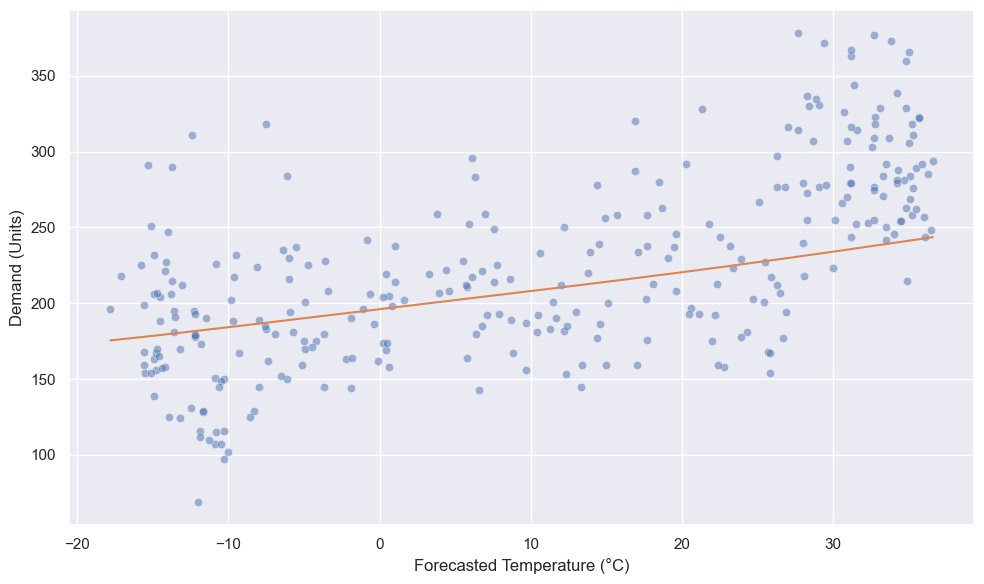

In [73]:
fig = plt.figure(figsize=(10, 6))
ax = sns.scatterplot(x="TEMPERATURE", y="DEMAND", data=predictions, c="C0", alpha=0.5)
ax = sns.lineplot(x="TEMPERATURE", y="YHAT", data=predictions, c="C1")

ax.set_xlabel("Forecasted Temperature (°C)")
ax.set_ylabel("Demand (Units)")

fig.tight_layout()

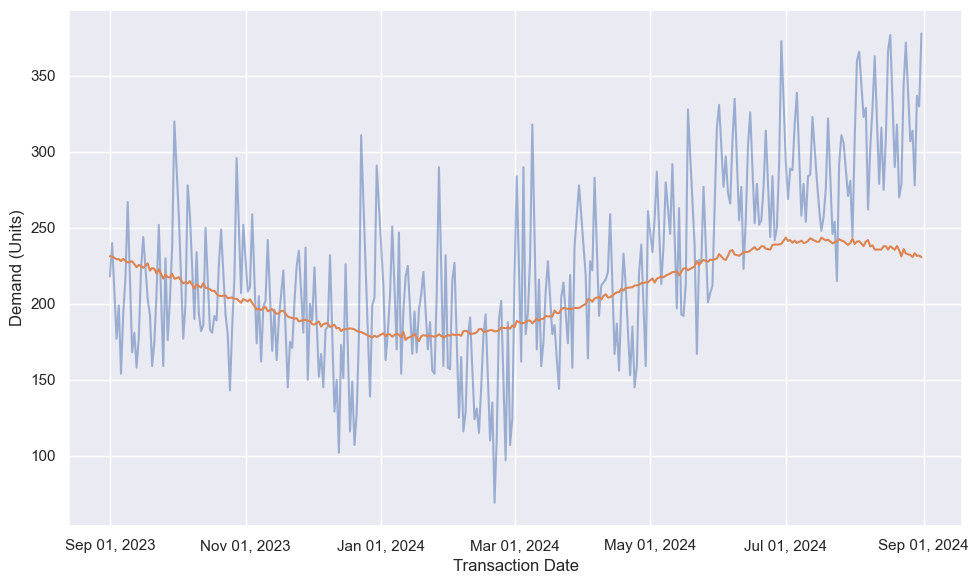

In [74]:
fig = plt.figure(figsize=(10, 6))
ax = sns.lineplot(x="TDATE", y="DEMAND", data=predictions, c="C0", alpha=0.5)
ax = sns.lineplot(x="TDATE", y="YHAT", data=predictions, c="C1")

ax.set_xlabel("Transaction Date")
ax.set_ylabel("Demand (Units)")

ax.xaxis.set_major_formatter(DateFormatter("%b %d, %Y"))

fig.tight_layout()

## Data Preparation and Evaluation for Multivariate Modeling

After completing the univariate analysis notebook, you can continue your exploration of demand forecasting by accessing the next notebook, which focuses on multivariate analysis. This upcoming notebook will introduce more sophisticated methods, including feature engineering and outlier handling, to enhance your analysis. Click [here](https://github.com/saschaschworm/big-data-and-data-science/labs/demand-forecasting-advanced.ipynb) to dive into these advanced techniques and further expand your understanding of data science in the context of demand forecasting.